In [19]:
import requests
from IPython.core.display import HTML
HTML(f"""
<style>
@import "https://cdn.jsdelivr.net/npm/bulma@0.9.4/css/bulma.min.css";
</style>
""")

# Principal Component Analysis (PCA)
In this in-class exercise you will be guided through the steps necessary for implementing a PCA on a sequence of human poses. You will work with the poses data, which was used for the exercises in week 6
. The dataset has a shape of $(1403, 100, 25*2)$. This means that there are 1403 pose sequences. Each sequence is a 100-frames time series capturing human poses. Each pose consists of 25 skeletal joints, where each joint is an x and y coordinate ($25*2$). For this exercise, you will use a single pose sequence of 100 frames and apply dimension reduction to the selected sequence. 
The following cells loads the neccessary libraries, the dataset and provides functions for plotting the poses:


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

# Suppress the specific warning
warnings.filterwarnings("ignore")

In [21]:
def limb_number_plot(s_pose_x,s_pose_y,n1,n2,c="red",label=None):
  if label is not None:
    if (s_pose_x[n1]>0) and (s_pose_x[n2]>0) and (s_pose_y[n1]>0) and (s_pose_y[n2]>0): 
      plt.plot([s_pose_x[n1],s_pose_x[n2]], [s_pose_y[n1], s_pose_y[n2]],color = c, linestyle="-",label=label)
  else:
    if (s_pose_x[n1]>0) and (s_pose_y[n1]>0):
       plt.plot(s_pose_x[n1], s_pose_y[n1],'*',color = c,label=label)
    if (s_pose_x[n2]>0) and (s_pose_y[n2]>0):
       plt.plot(s_pose_x[n2], s_pose_y[n2],'*',color = c,label=label)
    if (s_pose_x[n1]>0) and (s_pose_x[n2]>0) and (s_pose_y[n1]>0) and (s_pose_y[n2]>0):
      plt.plot([s_pose_x[n1],s_pose_x[n2]], [s_pose_y[n1], s_pose_y[n2]],color = c, linestyle="-")

def plot_single_pose(s_pose,c = "darkgreen",label=None,ds='body_25',c_head = 'red',head = True):
    
    s_pose_x=s_pose[::2]
    s_pose_y=s_pose[1::2]
    #torso/body
    limb_number_plot(s_pose_x,s_pose_y,2,5,c)
    if label is not None:

        limb_number_plot(s_pose_x,s_pose_y,9,12,c,label)
    else:
        limb_number_plot(s_pose_x,s_pose_y,9,12,c)
    limb_number_plot(s_pose_x,s_pose_y,2,9,c)
    limb_number_plot(s_pose_x,s_pose_y,5,12,c)

    #left arm (person facing away)
    limb_number_plot(s_pose_x,s_pose_y,2,3,c)
    limb_number_plot(s_pose_x,s_pose_y,3,4,c)

    #right arm
    limb_number_plot(s_pose_x,s_pose_y,5,6,c)
    limb_number_plot(s_pose_x,s_pose_y,6,7,c)

    #left leg / foot
    limb_number_plot(s_pose_x,s_pose_y,9,10,c)
    limb_number_plot(s_pose_x,s_pose_y,10,11,c)
    limb_number_plot(s_pose_x,s_pose_y,11,22,c)
    #right leg / foot
    limb_number_plot(s_pose_x,s_pose_y,12,13,c)
    limb_number_plot(s_pose_x,s_pose_y,13,14,c)
    limb_number_plot(s_pose_x,s_pose_y,14,19,c)

    # head
    if head:
        limb_number_plot(s_pose_x,s_pose_y,0,15,c)
        limb_number_plot(s_pose_x,s_pose_y,0,16,c)

        limb_number_plot(s_pose_x,s_pose_y,15,17,c)
        limb_number_plot(s_pose_x,s_pose_y,16,18,c)
    return True 

def plot_single_sequence(poses, pose_name='Poses',color='blue'):
    """
    Plots a single sequence of skeleton joints.

    Parameters:
        poses (array-like): Skeleton sequence data, shape (T,D).
        poses_name (string, optional): subtitle of each skeleton body in the sequence. 
        color (string, optional): color of skeleton bodies. 
    """
    plt.style.use('seaborn')
    plt.figure(figsize=(25,5))
    plt.title('Ground truth')

    for i in range(len(poses)):
        plt.subplot(5, 10, i + 1)
        plot_single_pose(poses[i], c=color, head=True)
        plt.ylim(1, 0)
        plt.xlim(-1, 1)
        plt.title(pose_name + str(i))
        plt.axis('off')

    plt.show()

## 1. Data inspection
The cell below:
1. Loads the data and construct data matrix.
2. Reshapes the data into a $100x50$ data-matrix: we want to implement dimension reduction on the entire chosen sequence, therefore we first flatten the array. 
3. Selects the first 50 frames from a single pose sequence and plot it.


---
**Task 1 (easy): Loading and inspecting the data👩‍💻**
1. Run the code cell
2. Change the code to display the display sequences 4,5,7 and visually observe how these sequences vary. 


---

(1403, 100, 25, 2)


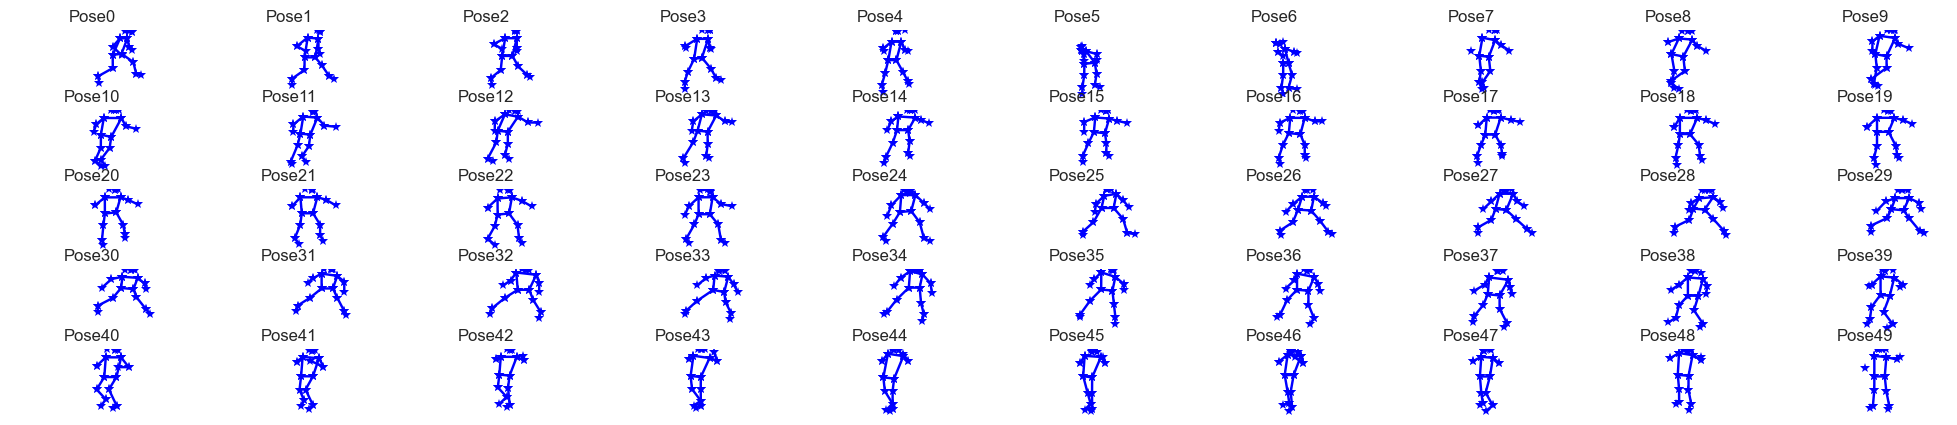

In [22]:
data = np.load('poses_norm.npy')
print(data.shape)
N,T,D,C = data.shape
reshaped_data = data.reshape(N,T,D*C)
dataset = reshaped_data[19]

# Define the new shape you want (30, 50)
new_shape = (50, 50)
# Reshape the array to the new shape
reshaped_data2 = np.empty(new_shape)  # Create an empty array with the new shape
reshaped_data2[:] = dataset[:new_shape[0], :]  

plot_single_sequence(reshaped_data2,pose_name='Pose',color='blue')

## 2. Covariance matrix
The following tasks construct and inspect the covariance matrix for the chosen pose sequence. 

---
**Task 2 (easy): Covariance matrix - NumPy method👩‍💻**
1. Run the cell below to obtain and plot the covariance matrix. We will use the covariance matrix obtained here in later parts of the exercise as well. 
2. What does the heatmap tell us about the relationship between the variables? 


---

<Axes: >

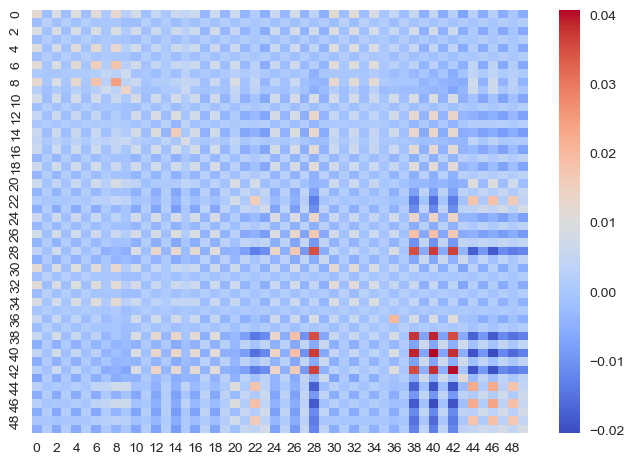

In [23]:
# Calculate the covariance matrix for the entire dataset
cov_matrix = np.cov(dataset, rowvar=False)
# Plotting
sns.heatmap(cov_matrix, cmap='coolwarm')


---
**Task 3 (easy): Rearranging the data👩‍💻**
Currently, the dataset is arranged by frames, with each frame being defined by an x and y coordinate. 
1. Run the cell below to rearrange the dataset. Rearranging is done just for illustrative purposes. 
2. How are the x and y coordinates arranged after rearranging the data?


---

In [24]:
# Get the number of rows and columns in the dataset
num_rows, num_columns = dataset.shape

# Separate even and odd columns
even_indexes = np.arange(0, num_columns, 2)  # Even indexes (0, 2, 4, ...)
odd_indexes = np.arange(1, num_columns, 2)   # Odd indexes (1, 3, 5, ...)

# Rearrange the dataset
rearranged_dataset = dataset[:, np.concatenate((even_indexes, odd_indexes))]


---
**Task 4 (medium): Covariance matrix - custom method👩‍💻**
Use the `rearranged_dataset`
 to:
1. Construct the covariance matrix using the formula:


$$

\mathbf{C} = \frac{1}{N} \sum_{i=1}^{N} (\mathbf{x}_i - \boldsymbol{\bar{x}})(\mathbf{x}_i - \boldsymbol{\bar{x}})^\top

$$
where $\mathbf{x}_i$ represents the $i$-th coordinate in the dataset and $\boldsymbol{\bar{x}}$ is the mean vector obtained by averaging the coordinates for each joint $\boldsymbol{\bar{x}} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{x}_i$

**Hint**
To center the data first calculate the mean vector, then subtract it from each data point of the pose sequence.

2. Create a heatmap of the covariance matrix.
3. Compare the covariance matrix obtained in this task to the one obtained in the previous task. How and why are they similar/different?


---

<Axes: >

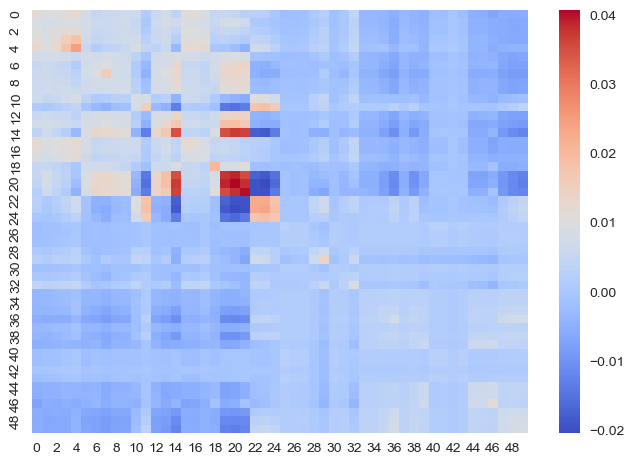

In [25]:
# write your solution here
test = np.cov(rearranged_dataset, rowvar=False)
sns.heatmap(test, cmap='coolwarm')


---
**Task 5 (easy): (Optional) Reflection💡**
- How would you change the above pipeline for obtaining the covariance matrix if you wanted to implement PCA on all of the 1403 pose sequences? 


---## 3. Eigenvalues and eigenvectors
Through the following steps you will implement the eigen decompositon and inspect crucial properties of the covariance matrix. 

---
**Task 6 (easy): Eigen decomposition👩‍💻**
1. Run the cell below to find the eigenvalues and eigenvectors.
2. Plot the eigenvalues. The plot should have a similar format to the given output.


---

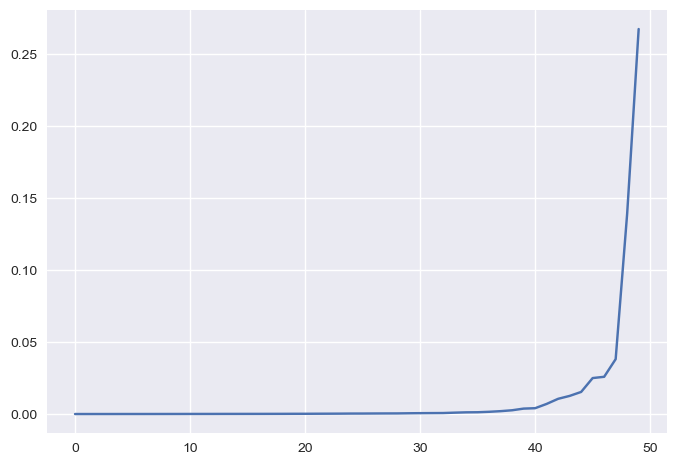

In [26]:
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# write your solution here
plt.plot(eigenvalues)


---
**Task 7 (easy): Properties of eigenvalues and eigenvectors👩‍💻**
1. Determine whether all of the eigenvalues are non-negative (greater than or equal to 0)
2. Verify that the obtained eigenvectors are orthogonal. An efficient way is to use the definition of an orthonormal matrix. Alternatively, you can verify them individually.


**Hint**
Notice that the values may be slightly imprecise due to the finite precision of numerical representations. You can use `np.isclose`
 to check whether two values are close to each other or not.

3. What is the total variance of the dataset? 


**Hint**
The sum of all eigenvalues should equal (approximately) the total variance in the original data.


---

In [27]:
print("All eigen values are 0 or above(which can be seen on the graph above)")
x = eigenvectors.T @ eigenvectors

id_m = np.identity(x.shape[0])
if np.isclose(x, id_m).all():
    print("All eigenvectors are othogonal to each other(because A^T * A == Identity_matrix)")    
else:
    print("The are not")

print("The sum of all the eigenvalues are: ", np.sum(eigenvalues))

All eigen values are 0 or above(which can be seen on the graph above)
All eigenvectors are othogonal to each other(because A^T * A == Identity_matrix)
The sum of all the eigenvalues are:  0.5649677720470421



---
**Task 8 (easy): Sorting Eigenvalues and Eigenvectors👩‍💻**
1. Sort the eigenvectors and their corresponding eigenvalues in descending order based on the eigenvalues. 
2. Plot the sorted eigenvalues. The plot should have a similar format to the given output.


---

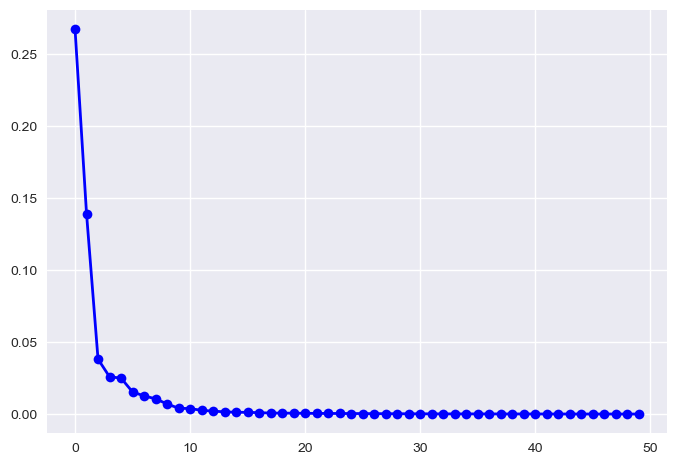

In [28]:
values = []
for i in range(eigenvalues.shape[0]):
    values.append((eigenvalues[i], eigenvectors[:,i]))

values.sort(key=lambda x: x[0], reverse=True)
sorted_eigenvalues = []
sorted_eigenvectors = []

for v in values:
    sorted_eigenvalues.append(v[0])
    sorted_eigenvectors.append(v[1])

sorted_eigenvectors = np.array(sorted_eigenvectors)
sorted_eigenvalues = np.array(sorted_eigenvalues)

plt.plot(sorted_eigenvalues, 'o-', linewidth=2, color='blue')


---
**Task 9 (easy): Select components👩‍💻**
The cell below calculates the cumulative explained variance ratio.

**Info**
By using this cutoff point we want to retain 95% of the variation in the original data. Remember that the sum of the selected eigenvalues can be used as a measure of how much variance is retained.

1. Plot the cumulative variance. The plot should have a similar format to the given output.
2. How many components do you need to retain: $50$%, $80$%, $90$%, $95$% of the variation
3. Select and print $k$ such that $95$% of the variation is retained.


---

index:  0  has ratio  0.47326401053637546
index:  1  has ratio  0.7195972532720218
index:  2  has ratio  0.7870763213261966
index:  3  has ratio  0.8328542500873792
index:  4  has ratio  0.8770746287106292
index:  5  has ratio  0.9042430414033059
index:  6  has ratio  0.9265331171995483
index:  7  has ratio  0.9452541034273317
index:  8  has ratio  0.957689424385687
index:  9  has ratio  0.9648611970151597
(50, 9)


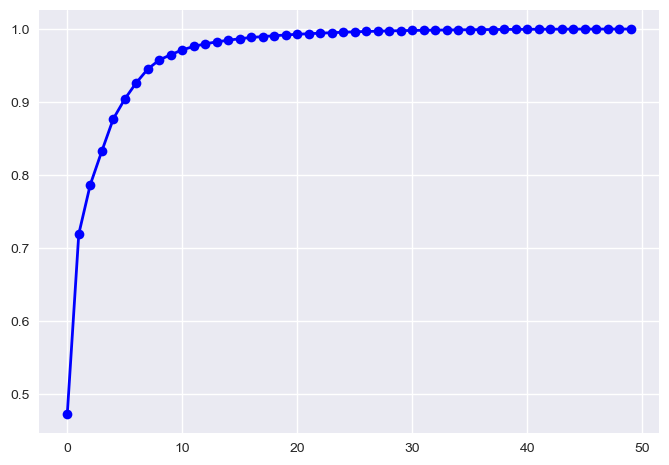

In [36]:
cumulative_variance_ratio = np.cumsum(sorted_eigenvalues) / np.sum(sorted_eigenvalues)

# Write your solution here
plt.plot(cumulative_variance_ratio, 'o-', linewidth=2, color='blue')

# Write your solution here
for i, v in np.ndenumerate(cumulative_variance_ratio):
    if i[0] < 10:
        print("index: ", i[0], " has ratio ", v)



## 4. Mixing parameters (Optional)
The following section describes how much each variable contributes to the selected principal components:

---
**Task 10 (medium): Mixing parameters👩‍💻**
1. Change the cell below to construct the $\Phi$ matrix containing the first 9 eigenvectors. The matrix is constructed as follows:


$$
{\Phi} = 
\begin{bmatrix}
    | & | & \cdots & | \\
    \vec{v}_1 & \vec{v}_2 & \cdots & \vec{v}_9 \\
    | & | & \cdots & |
\end{bmatrix}
$$
2. Define the mixing parameters as $\Phi_{i} \cdot \sqrt{\lambda_i}$, where $\Phi_{i}$ represents the $i$-th column of $\Phi$ (the selected eigenvectors) and $\lambda_i$ represents the corresponding eigenvalue. 


---

In [37]:
# Write your solution here

selected_eigenvectors = sorted_eigenvectors[:,0:9]
print(selected_eigenvectors.shape)
# print(mixing_params.shape)

(50, 9)



---
**Task 11 (medium): Plot the loadings👩‍💻**
- Plot the contribtuion of each variable to the principal components. The plot should have a similar format to the given output.


---

In [31]:
# Write your solution here


---
**Task 12 (easy): Reflection💡**
- What do positive and negative component loadings indicate in PCA, and how do they relate to the original variables?


---## 5. Generative process - Projecting to subspace and back
We can project the normalized data onto the selected principal components. This is done by taking the dot product of the data matrix with the eigenvector matrix, where each column represents a principal component. The following steps will implement this process. 

---
# 5. Generative process - Projecting to subspace and back

We can project the normalized data onto the selected principal components. This is done by taking the dot product of the data matrix with the eigenvector matrix, where each column represents a principal component. The following steps will implement this process.

**Task 13 (easy): Project to subspace👩‍💻**
Run the cell below to make sure that your data is centered. Use the centered data to:
1. Project the original data onto the selected eigenvectors. 


**Hint**
Dot product.

2. To plot the projected data using the given code.


---

In [39]:
# Calculate the mean vector
mean_vector = np.mean(dataset, axis=0)

# Subtract the mean from each data point
centered_data = dataset - mean_vector

# Write your solution here
projected_data = selected_eigenvectors.dot(centered_data)

# Create a scatter plot for each pair of components for 9 components
plt.figure(figsize=(15, 15))
for i in range(9):
    for j in range(9):
        plt.subplot(9, 9, (i * 9) + j + 1)
        plt.scatter(projected_data.T[:, i], projected_data.T[:, j], marker=".")
        plt.xlabel(f'PC {i + 1}')
        plt.ylabel(f'PC {j + 1}')
        plt.title(f'PC {i + 1} vs. PC {j + 1}')
        plt.xlim([-1.5, 1.5]) 
        plt.ylim([1.5, -1.5])  
plt.tight_layout()
plt.show()

print(projected_data.T.shape)

ValueError: shapes (9,50) and (100,50) not aligned: 50 (dim 1) != 100 (dim 0)


---
**Task 14 (easy): Project back to original space👩‍💻**
1. Project the data back from the PCA space to the original data space using the selected eigenvectors. 


**Hint**
Dot product. Remember to add the mean!


---

In [33]:
# Write your solution here
reconstructed_data = projected_data.T.dot(selected_eigenvectors) + mean_vector

print(reconstructed_data.shape)

(100, 50)



---
**Task 15 (medium): Plotting original and reconstructed data👩‍💻**
- Plot the first 50 frames from both the original and the reconstructed data. 


---

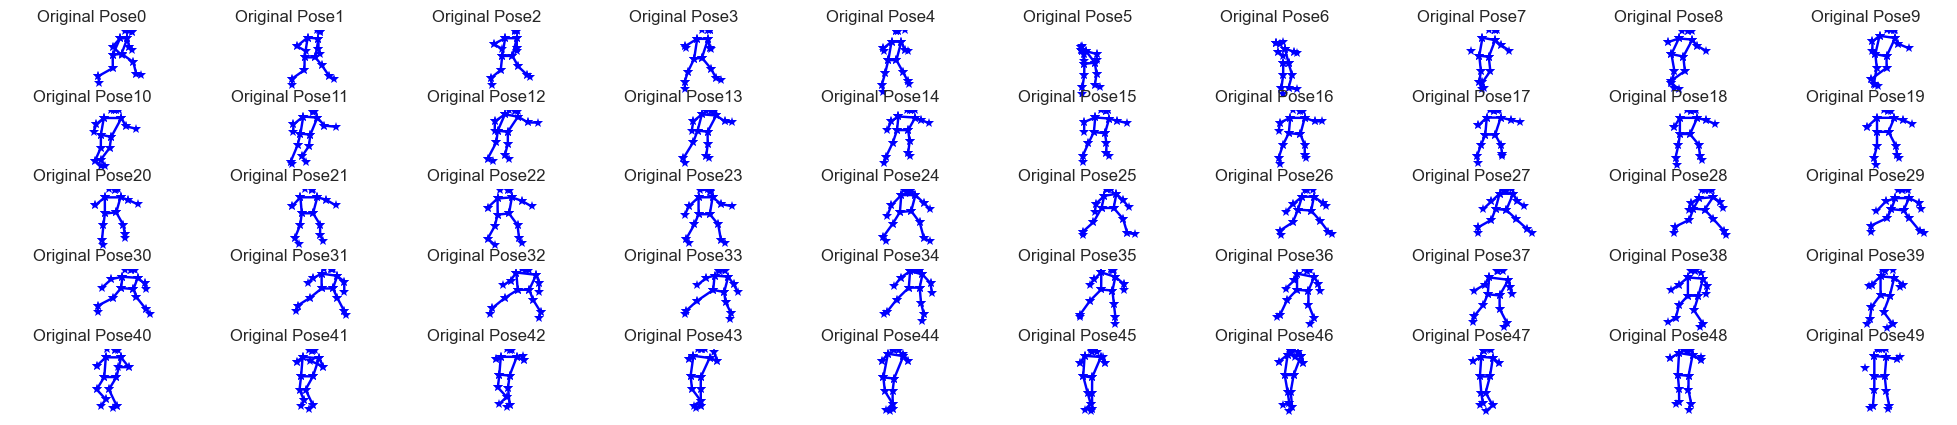

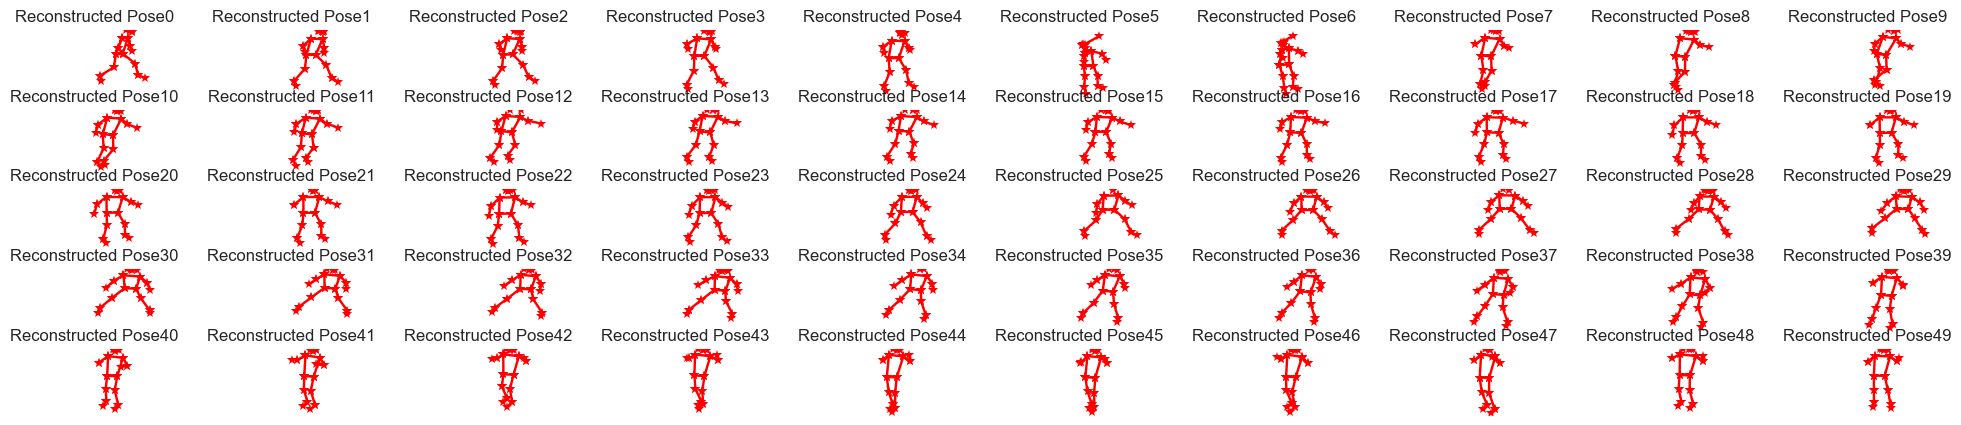

In [34]:
plot_single_sequence(reshaped_data2, pose_name="Original Pose", color='blue')
plot_single_sequence(reconstructed_data[0:50],pose_name='Reconstructed Pose', color='red')


---
**Task 16 (easy): Plotting original and reconstructed data👩‍💻**
- Change the number of components selected and rerun the process. 


---

(9, 50)
[[-0.10384661  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.22549518  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.

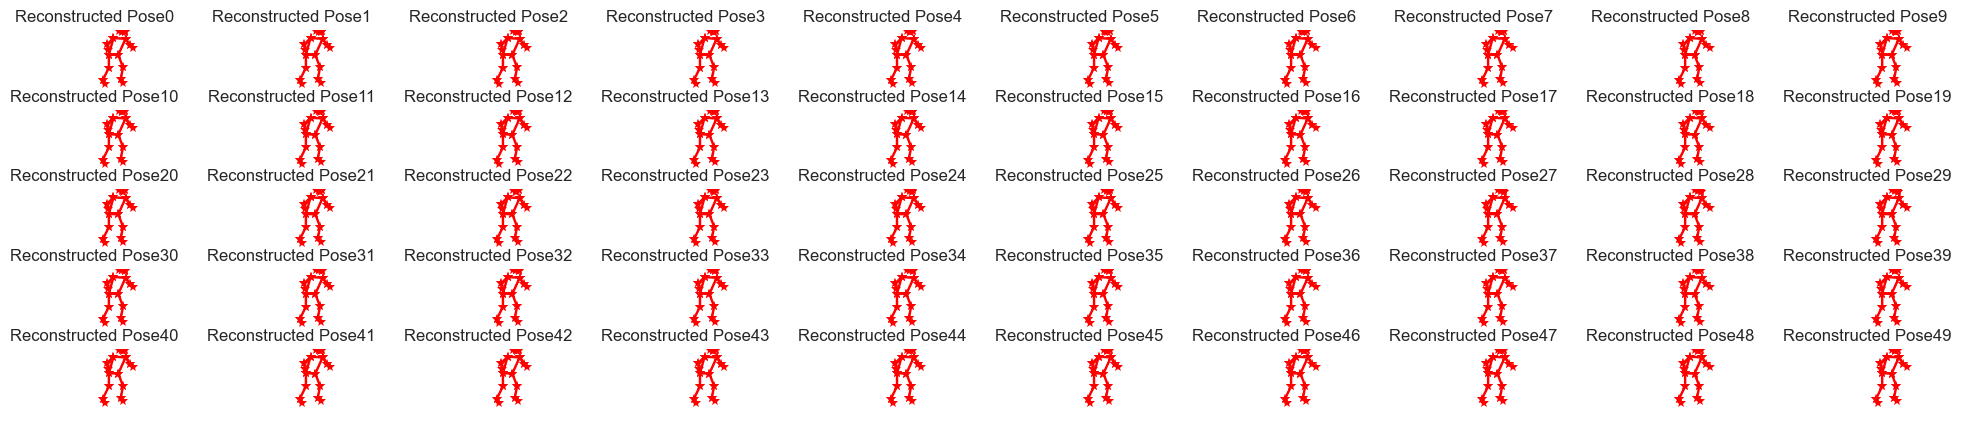

In [35]:
def select_comp(k):
    k_selected_comp_eigenvectors = np.zeros(selected_eigenvectors.shape)
    for i in range(k):
        k_selected_comp_eigenvectors[0,i] = selected_eigenvectors[0,i]
        k_selected_comp_eigenvectors[1,i] = selected_eigenvectors[1,i]
        k_selected_comp_eigenvectors[2,i] = selected_eigenvectors[2,i]
        k_selected_comp_eigenvectors[3,i] = selected_eigenvectors[3,i]
        k_selected_comp_eigenvectors[4,i] = selected_eigenvectors[4,i]
        k_selected_comp_eigenvectors[5,i] = selected_eigenvectors[5,i]
        k_selected_comp_eigenvectors[6,i] = selected_eigenvectors[6,i]
        k_selected_comp_eigenvectors[7,i] = selected_eigenvectors[7,i]
        k_selected_comp_eigenvectors[8,i] = selected_eigenvectors[8,i]

    return k_selected_comp_eigenvectors

k_selected_comp_eigenvectors = select_comp(1)

print(k_selected_comp_eigenvectors.shape)
print(k_selected_comp_eigenvectors)

proj_data = k_selected_comp_eigenvectors.dot(centered_data.T)
res_data = proj_data.T.dot(k_selected_comp_eigenvectors) + mean_vector

plot_single_sequence(res_data[0:50],pose_name='Reconstructed Pose', color='red')